In [1]:
from liblet import Grammar, Derivation, Production, ProductionGraph, show_calls, iter2table

# Naïve recursive descent non funziona

Se la grammatica non è *prefix-free*…

In [2]:
import nbimporter
from L12 import make_match_source, make_match

Importing Jupyter notebook from L12.ipynb


In [3]:
G = Grammar.from_string("""
S -> A | a B
A -> a
B -> b
""")
match = make_match(make_match_source(G))

In [4]:
match('S', 'a')

┌match('S', 'a')
│┌match('A', 'a')
││┌match('a', 'a')
││└─ (True, '')
│└─ (True, '')
└─ (True, '')


(True, '')

In [5]:
match('S', 'ab')

┌match('S', 'ab')
│┌match('A', 'ab')
││┌match('a', 'ab')
││└─ (True, 'b')
│└─ (True, 'b')
└─ (True, 'b')


(True, 'b')

# Continuazioni

In [6]:
def sum(x, y):
    return x + y

print(sum(3, 4))

7


In [7]:
def sum_c(x, y, cont):
    cont(x + y)
    
sum_c(4, 5, print)

9


In [8]:
def mul_c(x, y, cont):
    cont(x * y)
    
mul_c(3, 9, print)

27


In [9]:
# print(3 * (4 + 5))

def mul_sum(x, y, z, cont):
    def t(v):
        mul_c(x, v, cont)
    sum_c(y, z, t)

mul_sum(3, 4, 5, print)

27


In [10]:
def double(p, cont):
    print('This is double on', p)
    cont(2 * p)

double('ciao', print)

This is double on ciao
ciaociao


In [11]:
def ucfirst(p, cont):
    print('This is uppercase on', p)
    cont(p.capitalize())

ucfirst('ciao', print)    

This is uppercase on ciao
Ciao


In [12]:
def reverse(p, cont):
    print('This is reverse on', p)
    cont(p[::-1])
    
reverse('ciao', print)    

This is reverse on ciao
oaic


In [13]:
def dur(p, cont):
    def tt(p):
        def t(p):
            reverse(p, cont)
        ucfirst(p, t)
    double(p, tt)

dur('ciao', print)

This is double on ciao
This is uppercase on ciaociao
This is reverse on Ciaociao
oaicoaiC


## E il parsing?

In [14]:
@show_calls(False)
def match(X, rest, tail):

    def S_alt0(rest):
        match('A', rest, tail)

    def S_alt1(rest):
        def t(rest):
            match('B', rest, tail)
        match('a', rest, t)

    def B(rest):
        match('b', rest, tail)

    def A(rest):
        match('a', rest, tail)


    if X in {'a', 'b'}:

        if rest and rest[0] == X: tail(rest[1:])

    if X == 'S':

        S_alt0(rest)
        S_alt1(rest)

    elif X == 'A': 

        A(rest)

    elif X == 'B': 
        
        B(rest)

In [15]:
def end_match(rest):
    if not rest: print('match')

In [16]:
match('S', 'ab', end_match)

match('S', 'ab', <function end_match at 0x10bfeae18>)
 match('A', 'ab', <function end_match at 0x10bfeae18>)
  match('a', 'ab', <function end_match at 0x10bfeae18>)
 match('a', 'ab', <function match.<locals>.S_alt1.<locals>.t at 0x10b9fa158>)
  match('B', 'b', <function end_match at 0x10bfeae18>)
   match('b', 'b', <function end_match at 0x10bfeae18>)
match


In [17]:
match('S', 'a', end_match)

match('S', 'a', <function end_match at 0x10bfeae18>)
 match('A', 'a', <function end_match at 0x10bfeae18>)
  match('a', 'a', <function end_match at 0x10bfeae18>)
match
 match('a', 'a', <function match.<locals>.S_alt1.<locals>.t at 0x10c024400>)
  match('B', '', <function end_match at 0x10bfeae18>)
   match('b', '', <function end_match at 0x10bfeae18>)


# Parsing con le continuazioni (tenendo traccia delle derivazioni)

In [18]:
iter2table(G.P)

In [19]:
def match(deriv, X, rest, tail):

    def S_alt0(deriv, rest):
        match(deriv, 'A', rest, tail)

    def S_alt1(deriv, rest):
        def t(deriv, rest):
            match(deriv, 'B', rest, tail)
        match(deriv, 'a', rest, t)
    
    def B(deriv, rest):
        match(deriv, 'b', rest, tail)

    def A(deriv, rest):
        match(deriv, 'a', rest, tail)

    if X in {'a', 'b'}:

        if rest and rest[0] == X: tail(deriv, rest[1:])

    elif X == 'S':
        
        S_alt0(deriv.leftmost(0), rest)
        S_alt1(deriv.leftmost(1), rest)

    elif X == 'A': 
        
        A(deriv.leftmost(2), rest)

    elif X == 'B': 
        
        B(deriv.leftmost(3), rest)

In [20]:
def end_match(deriv, rest):
    if not rest: print(deriv)

In [21]:
match(Derivation(G), 'S', 'ab', end_match)

S -> a B -> a b


In [22]:
match(Derivation(G), 'S', 'a', end_match)

S -> A -> a


# Un generatore di parser con continuazioni

In [23]:
def make_cps_match_source(G, show_calls = True):
    code_ifs = []
    code_defs = []
    code_ifs = ['\tif X in {}:\n\t\tif rest and rest[0] == X: tail(deriv, rest[1:])'.format(G.T)]
    
    for A in G.N:
        code_ifs.append("\telif X == '{}':".format(A))
        for a, α in enumerate(G.alternatives(A)):
            
            code_defs.append('\tdef {}_alt{}(deriv, rest):'.format(A, a))
            for t in range(1, len(α)):
                code_defs.append('\t{}def {}(deriv, rest):'.format('\t' * t, 't' * (len(α) - t)))
            for t, X in enumerate(reversed(α)):
                code_defs.append("\t{}match(deriv, '{}', rest, {})".format('\t' * (len(α) - t), X, 't' * t if t else 'tail'))

            d = G.P.index(Production(A, α))
            code_ifs.append('\t\t{}_alt{}(deriv.leftmost({}), rest)'.format(A, a, d))
    prefix = '@show_calls(False)\n' if show_calls else '' 
    return prefix + 'def match(deriv, X, rest, tail):\n' + '\n'.join(code_defs) + '\n' + '\n'.join(code_ifs)

In [24]:
G = Grammar.from_string("""
S -> a A | a b B
A -> a
B -> b
""")
source = make_cps_match_source(G, True)
print(source)

@show_calls(False)
def match(deriv, X, rest, tail):
	def B_alt0(deriv, rest):
		match(deriv, 'b', rest, tail)
	def S_alt0(deriv, rest):
		def t(deriv, rest):
			match(deriv, 'A', rest, tail)
		match(deriv, 'a', rest, t)
	def S_alt1(deriv, rest):
		def tt(deriv, rest):
			def t(deriv, rest):
				match(deriv, 'B', rest, tail)
			match(deriv, 'b', rest, t)
		match(deriv, 'a', rest, tt)
	def A_alt0(deriv, rest):
		match(deriv, 'a', rest, tail)
	if X in frozenset({'a', 'b'}):
		if rest and rest[0] == X: tail(deriv, rest[1:])
	elif X == 'B':
		B_alt0(deriv.leftmost(3), rest)
	elif X == 'S':
		S_alt0(deriv.leftmost(0), rest)
		S_alt1(deriv.leftmost(1), rest)
	elif X == 'A':
		A_alt0(deriv.leftmost(2), rest)


In [25]:
match = make_match(source)

In [26]:
match(Derivation(G), 'S', 'abb', end_match)

match(S, 'S', 'abb', <function end_match at 0x10bfea840>)
 match(S -> a A, 'a', 'abb', <function match.<locals>.S_alt0.<locals>.t at 0x10c42c268>)
  match(S -> a A, 'A', 'bb', <function end_match at 0x10bfea840>)
   match(S -> a A -> a a, 'a', 'bb', <function end_match at 0x10bfea840>)
 match(S -> a b B, 'a', 'abb', <function match.<locals>.S_alt1.<locals>.tt at 0x10c42c268>)
  match(S -> a b B, 'b', 'bb', <function match.<locals>.S_alt1.<locals>.tt.<locals>.t at 0x10c42c7b8>)
   match(S -> a b B, 'B', 'b', <function end_match at 0x10bfea840>)
    match(S -> a b B -> a b b, 'b', 'b', <function end_match at 0x10bfea840>)
S -> a b B -> a b b


## Un esempio maggiormente realistico

In [27]:
G = Grammar.from_string("""
E -> Eh Ets | Eh
Eh -> T
Ets -> Et Ets | Et
Et -> + T | - T
T -> Th Tts | Th
Th -> F
Tts -> Tt Tts | Tt
Tt -> * F | / F
F -> f
""")

In [28]:
match = make_match(make_cps_match_source(G, False))

In [29]:
match(Derivation(G), 'E', 'f*f+f', end_match)

E -> Eh Ets -> T Ets -> Th Tts Ets -> F Tts Ets -> f Tts Ets -> f Tt Ets -> f * F Ets -> f * f Ets -> f * f Et -> f * f + T -> f * f + Th -> f * f + F -> f * f + f


In [30]:
def end_match_display(deriv, rest):
    if not rest: display(ProductionGraph(deriv))

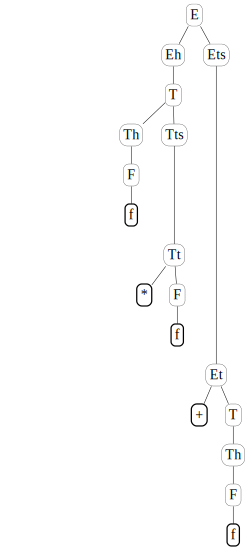

In [31]:
match(Derivation(G), 'E', 'f*f+f', end_match_display)

# Quindi abbiamo risolto?

In [32]:
G = Grammar.from_string("""
S -> A S | B S | #
A -> a
B -> a
""")

match = make_match(make_cps_match_source(G, False))

In [33]:
match(Derivation(G), 'S', 'aaaa#', end_match)

S -> A S -> a S -> a A S -> a a S -> a a A S -> a a a S -> a a a A S -> a a a a S -> a a a a #
S -> A S -> a S -> a A S -> a a S -> a a A S -> a a a S -> a a a B S -> a a a a S -> a a a a #
S -> A S -> a S -> a A S -> a a S -> a a B S -> a a a S -> a a a A S -> a a a a S -> a a a a #
S -> A S -> a S -> a A S -> a a S -> a a B S -> a a a S -> a a a B S -> a a a a S -> a a a a #
S -> A S -> a S -> a B S -> a a S -> a a A S -> a a a S -> a a a A S -> a a a a S -> a a a a #
S -> A S -> a S -> a B S -> a a S -> a a A S -> a a a S -> a a a B S -> a a a a S -> a a a a #
S -> A S -> a S -> a B S -> a a S -> a a B S -> a a a S -> a a a A S -> a a a a S -> a a a a #
S -> A S -> a S -> a B S -> a a S -> a a B S -> a a a S -> a a a B S -> a a a a S -> a a a a #
S -> B S -> a S -> a A S -> a a S -> a a A S -> a a a S -> a a a A S -> a a a a S -> a a a a #
S -> B S -> a S -> a A S -> a a S -> a a A S -> a a a S -> a a a B S -> a a a a S -> a a a a #
S -> B S -> a S -> a A S -> a a S -> a a B S -> a 

In [34]:
G = Grammar.from_string("""
S -> a A | a B
A -> a A | x 
B -> a B | y 
""")
print(G)
match = make_match(make_cps_match_source(G, True))

Grammar(N={A, B, S}, T={a, x, y}, P=(S -> a A, S -> a B, A -> a A, A -> x, B -> a B, B -> y), S=S)


In [35]:
match(Derivation(G), 'S', 'aaay', end_match)

match(S, 'S', 'aaay', <function end_match at 0x10bfea840>)
 match(S -> a A, 'a', 'aaay', <function match.<locals>.S_alt0.<locals>.t at 0x10c430a60>)
  match(S -> a A, 'A', 'aay', <function end_match at 0x10bfea840>)
   match(S -> a A -> a a A, 'a', 'aay', <function match.<locals>.A_alt0.<locals>.t at 0x10c451158>)
    match(S -> a A -> a a A, 'A', 'ay', <function end_match at 0x10bfea840>)
     match(S -> a A -> a a A -> a a a A, 'a', 'ay', <function match.<locals>.A_alt0.<locals>.t at 0x10c451620>)
      match(S -> a A -> a a A -> a a a A, 'A', 'y', <function end_match at 0x10bfea840>)
       match(S -> a A -> a a A -> a a a A -> a a a a A, 'a', 'y', <function match.<locals>.A_alt0.<locals>.t at 0x10c451e18>)
       match(S -> a A -> a a A -> a a a A -> a a a x, 'x', 'y', <function end_match at 0x10bfea840>)
     match(S -> a A -> a a A -> a a x, 'x', 'ay', <function end_match at 0x10bfea840>)
   match(S -> a A -> a x, 'x', 'aay', <function end_match at 0x10bfea840>)
 match(S -> a B, 